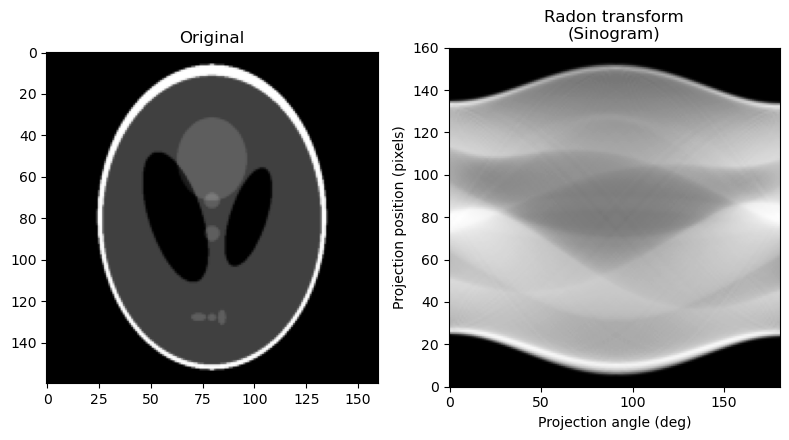

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

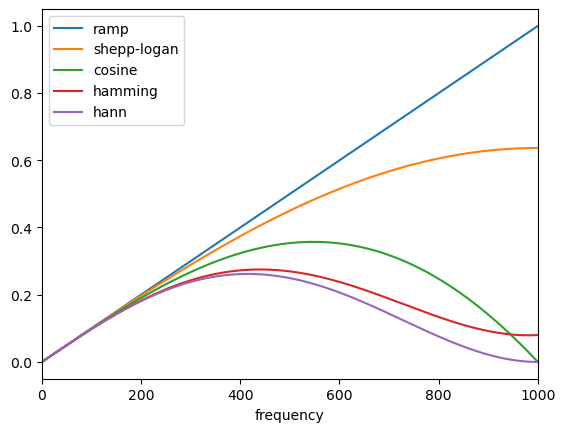

In [2]:
import matplotlib.pyplot as plt
from skimage.transform.radon_transform import _get_fourier_filter

filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    plt.plot(response, label=f)

plt.xlim([0, 1000])
plt.xlabel('frequency')
plt.legend()
plt.show()

FBP rms reconstruction error: 0.0283


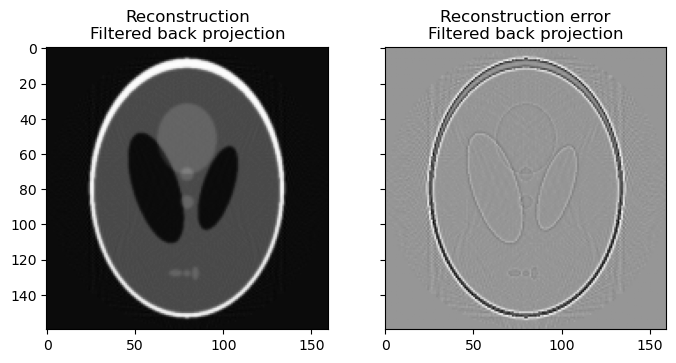

In [3]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

SART (1 iteration) rms reconstruction error: 0.0329
SART (2 iterations) rms reconstruction error: 0.0214
SART (3 iterations) rms reconstruction error: 0.0177


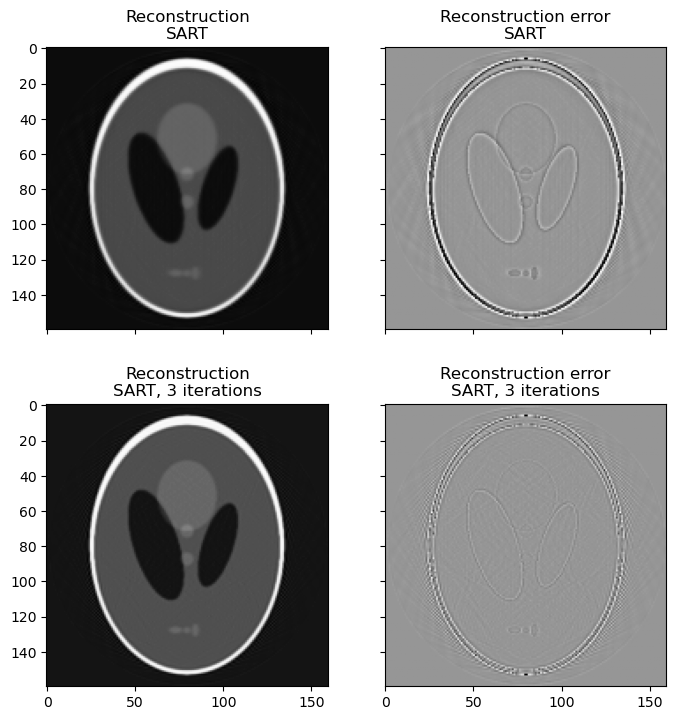

In [5]:
# SART 
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
error = reconstruction_sart - image
print(
    f'SART (1 iteration) rms reconstruction error: ' f'{np.sqrt(np.mean(error**2)):.3g}'
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r, **imkwargs)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta, image=reconstruction_sart)
error = reconstruction_sart2 - image
print(
    f'SART (2 iterations) rms reconstruction error: '
    f'{np.sqrt(np.mean(error**2)):.3g}'
)

ax[2].set_title("Reconstruction\nSART, 2 iterations")
ax[2].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 2 iterations")
ax[3].imshow(reconstruction_sart2 - image, cmap=plt.cm.Greys_r, **imkwargs)

# Running a third iteration
reconstruction_sart3 = iradon_sart(sinogram, theta=theta, image=reconstruction_sart)
error = reconstruction_sart3 - image
print(
    f'SART (3 iterations) rms reconstruction error: '
    f'{np.sqrt(np.mean(error**2)):.3g}'
)

ax[2].set_title("Reconstruction\nSART, 3 iterations")
ax[2].imshow(reconstruction_sart3, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 3 iterations")
ax[3].imshow(reconstruction_sart3 - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

# the image keeps getting better with each iteration

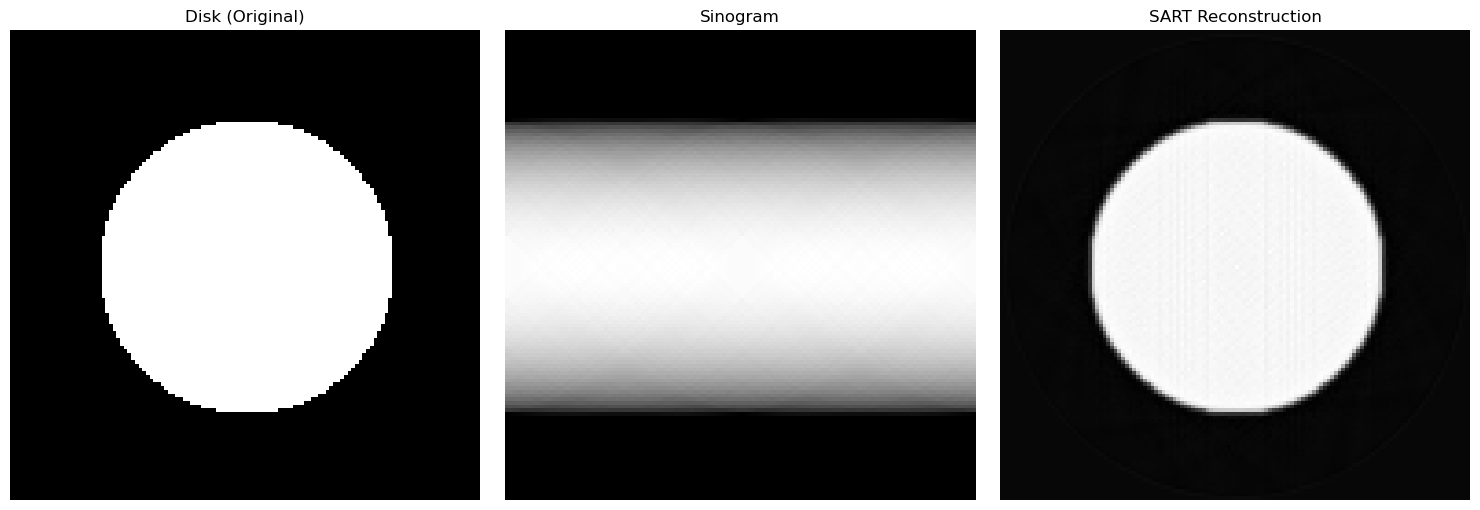

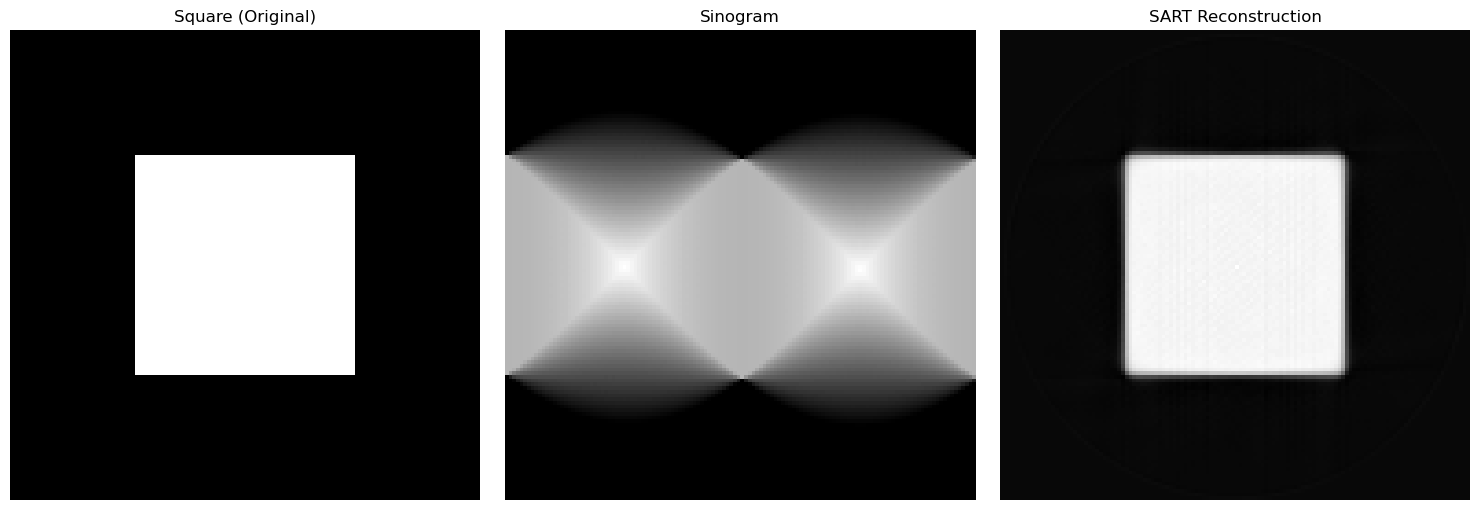

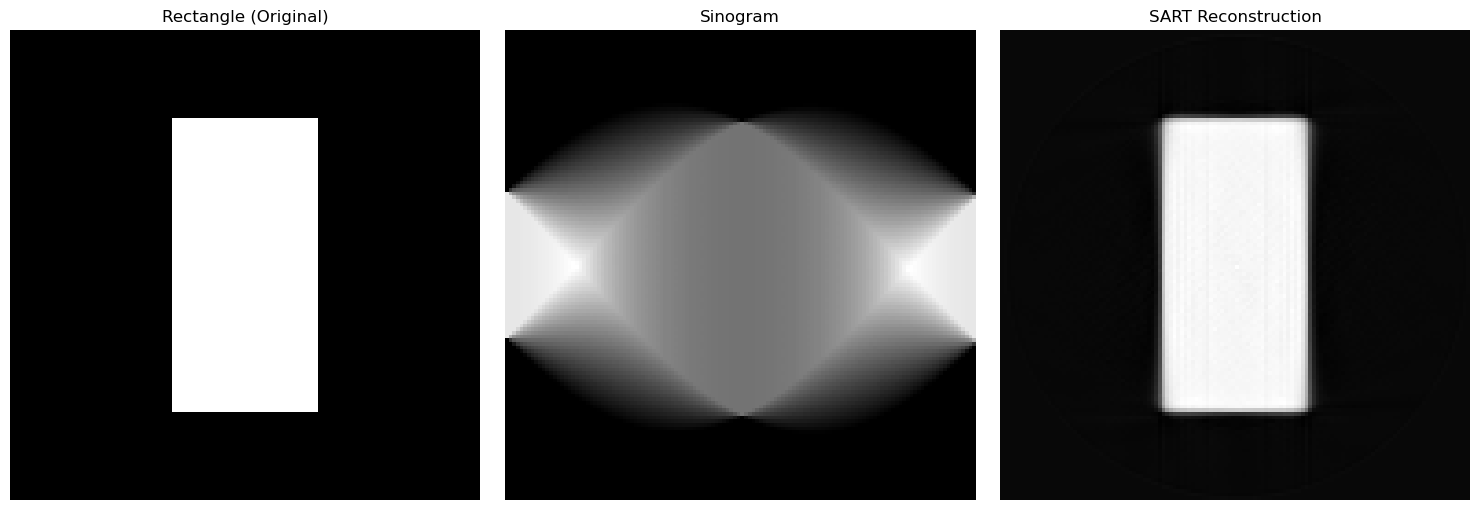

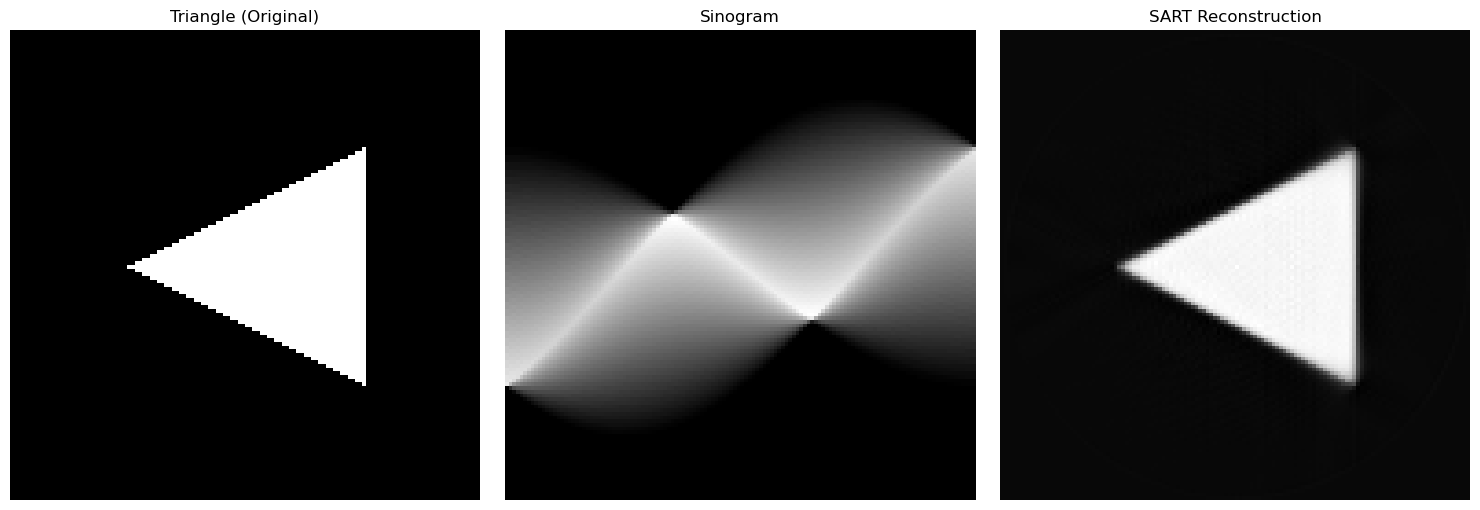

In [6]:
# Code with basic implementation of SART
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk, rectangle, polygon
from skimage.transform import radon, iradon_sart

# Utility function to display images side by side
def show_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Create blank phantom image
# acts like a canvas for drawing all the shapes
def make_blank(size=128):
    return np.zeros((size, size), dtype=float)

# 1. Disk
def make_disk(size=128, radius=40, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    rr, cc = disk(center, radius, shape=img.shape)
    img[rr, cc] = intensity
    return img

# 2. Square
def make_square(size=128, side=60, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    half = side//2
    start = (center[0]-half, center[1]-half)
    rr, cc = rectangle(start, extent=(side, side), shape=img.shape)
    img[rr, cc] = intensity
    return img

# 3. Rectangle
def make_rectangle(size=128, width=40, height=80, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    start = (center[0]-height//2, center[1]-width//2)
    rr, cc = rectangle(start, extent=(height, width), shape=img.shape)
    img[rr, cc] = intensity
    return img

# 4. Triangle
def make_triangle(size=128, intensity=1.0):
    img = make_blank(size)
    # Define 3 vertices of a triangle
    v = np.array([
        [size//4, 3*size//4],
        [size//2, size//4],
        [3*size//4, 3*size//4]
    ])
    rr, cc = polygon(v[:,0], v[:,1], img.shape)
    img[rr, cc] = intensity
    return img

# List of shapes and names
shapes = [
    (make_disk(), "Disk"),
    (make_square(), "Square"),
    (make_rectangle(), "Rectangle"),
    (make_triangle(), "Triangle")
]

# Angles for projections
theta = np.linspace(0., 180., max(shapes[0][0].shape), endpoint=False)

# Main loop over each shape: make sinogram, reconstruct, show results
for phantom, name in shapes:
    # 1. Show original
    # 2. Sinogram (Radon transform)
    sinogram = radon(phantom, theta=theta, circle=True)

    # 3. SART reconstruction from sinogram
    reconstruction_sart = iradon_sart(sinogram, theta=theta)

    # Display results
    show_images(
        [phantom, sinogram, reconstruction_sart],
        [f"{name} (Original)", "Sinogram", "SART Reconstruction"]
    )


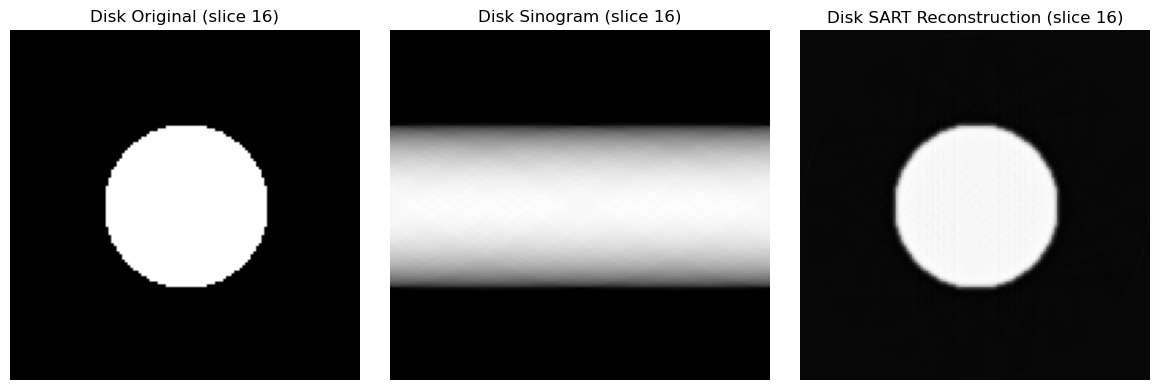

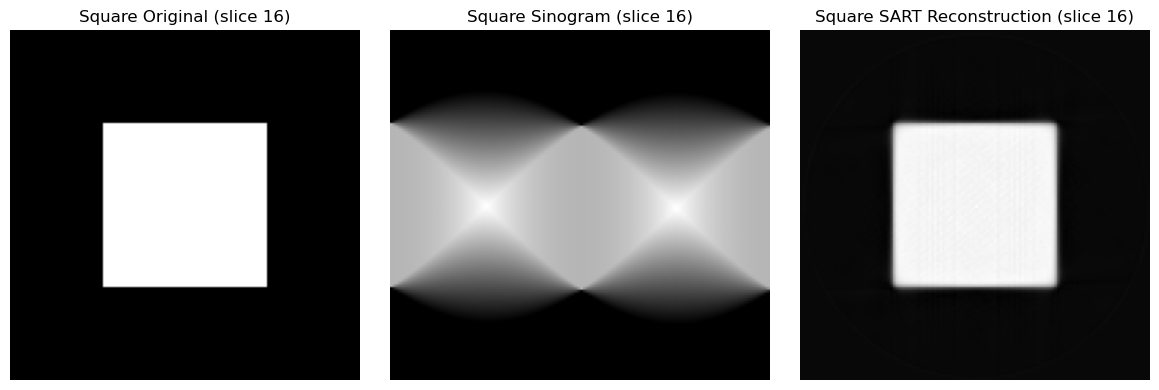

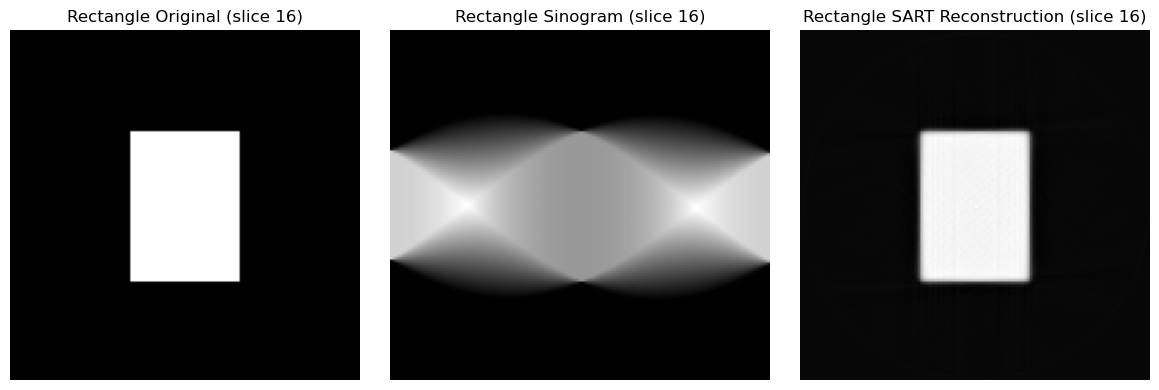

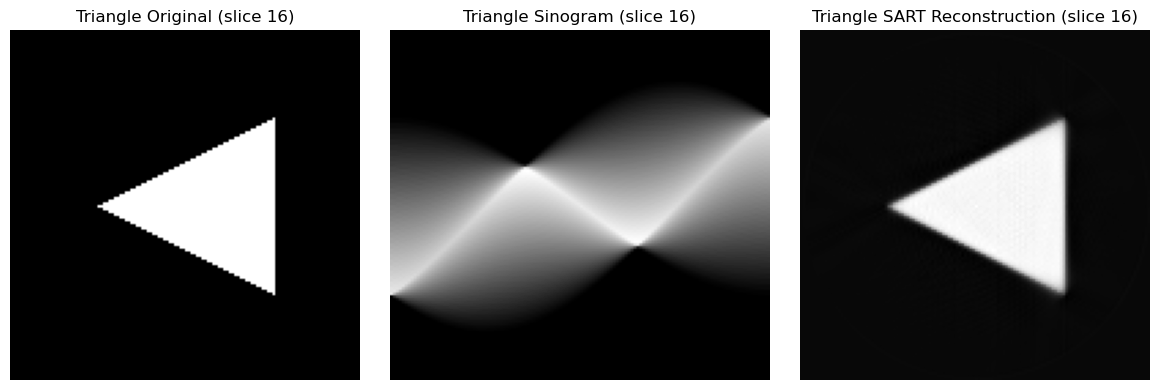

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

In [1]:
# Code with better implementation of SART 
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk, rectangle, polygon
from skimage.transform import radon, iradon_sart
import matplotlib.pyplot as plt 
from ipywidgets import interact 

size = 128  # slice image size
num_slices = 32  # number of slices for 3D volume

# helper functions for shape generation
def make_blank(size=size):
    return np.zeros((size, size), dtype=float)

def make_disk(size=size, radius=40, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    rr, cc = disk(center, radius, shape=img.shape)
    img[rr, cc] = intensity
    return img

def make_square(size=size, side=60, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    half = side//2
    start = (center[0]-half, center[1]-half)
    rr, cc = rectangle(start, extent=(side, side), shape=img.shape)
    img[rr, cc] = intensity
    return img

def make_rectangle(size=size, width=40, height=80, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    start = (center[0]-height//2, center[1]-width//2)
    rr, cc = rectangle(start, extent=(height, width), shape=img.shape)
    img[rr, cc] = intensity
    return img

def make_triangle(size=size, intensity=1.0):
    img = make_blank(size)
    v = np.array([
        # left bottom 
        [size//4, 3*size//4],
        # top middle 
        [size//2, size//4],
        # right bottom
        [3*size//4, 3*size//4]
    ])
    # polygon returns rr - row indices of all pixels 
    # and returns cc - col indices of all pixels
    rr, cc = polygon(v[:,0], v[:,1], img.shape)
    # color the triangle
    img[rr, cc] = intensity
    return img

# create 3D phantoms by stacking slightly varying 2D slices
phantom_disks = []
phantom_squares = []
phantom_rects = []
phantom_triangles = []
for i in range(num_slices):
    # slight variations in each slice for 3D "effect"
    # helps us oscillate the radius by +- 10 pixels
    phantom_disks.append(make_disk(radius=30 + int(10 * np.sin(2 * np.pi * i / num_slices))))
    # changes the vertical center of the square by +- 5 pixels
    center_shift = (size//2 + int(5 * np.sin(2 * np.pi * i / num_slices)), size//2)
    # creates a new square at its shifted position
    phantom_squares.append(make_square(center=center_shift))
    # osicllates the hegiht by +- 15 pixels 
    height = 70 + int(15 * np.cos(2 * np.pi * i / num_slices))
    # creates and saves a rect of the calculated height
    phantom_rects.append(make_rectangle(height=height))
    # we use sine wave to shift triangle's horizontal position
    shift = int(5 * np.sin(2 * np.pi * i / num_slices))
    # we make triangle's 3 vertices all moved by shift
    t_img = make_blank()
    v = np.array([
        [size//4 + shift, 3*size//4],
        [size//2 + shift, size//4],
        [3*size//4 + shift, 3*size//4]
    ])
    rr, cc = polygon(v[:,0], v[:,1], t_img.shape)
    t_img[rr, cc] = 1.0
    phantom_triangles.append(t_img)

# stack the lists into 3D arrays
phantom_disks = np.stack(phantom_disks)
phantom_squares = np.stack(phantom_squares)
phantom_rects = np.stack(phantom_rects)
phantom_triangles = np.stack(phantom_triangles)

# sinogram and SART reconstruction for each slice

# theta values from 0->180
theta = np.linspace(0., 180., size, endpoint=False)

def reconstruct_stack(phantom_stack):
    # make sinograms for all the stacks 
    sinograms = np.array([radon(phantom_stack[i], theta=theta, circle=True) for i in range(num_slices)])
    # reconstruc the images for all the stacks 
    recons = np.array([iradon_sart(sinograms[i], theta=theta) for i in range(num_slices)])
    return sinograms, recons

sino_disks, rec_disks = reconstruct_stack(phantom_disks)
sino_squares, rec_squares = reconstruct_stack(phantom_squares)
sino_rects, rec_rects = reconstruct_stack(phantom_rects)
sino_triangles, rec_triangles = reconstruct_stack(phantom_triangles)

# visualizations
slice_idx = num_slices // 2

# function to print the visualizations 
def show_slice_set(origin, sino, rec, name):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(origin, cmap='gray')
    plt.title(f'{name} Original (slice {slice_idx})')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(sino, cmap='gray', aspect='auto')
    plt.title(f'{name} Sinogram (slice {slice_idx})')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(rec, cmap='gray')
    plt.title(f'{name} SART Reconstruction (slice {slice_idx})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# function to show the volume of the images as well 
def show_volume(volume, title = ''):
    def view_slice(idx):
        plt.figure(figsize = (5,5))
        plt.imshow(volume[idx], cmap = 'gray')
        plt.title(f'{title}, slice {idx}')
        plt.axis('off')
        plt.show()
    interact(view_slice, idx = (0, volume.shape[0]-1))



show_slice_set(phantom_disks[slice_idx], sino_disks[slice_idx], rec_disks[slice_idx], 'Disk')
show_slice_set(phantom_squares[slice_idx], sino_squares[slice_idx], rec_squares[slice_idx], 'Square')
show_slice_set(phantom_rects[slice_idx], sino_rects[slice_idx], rec_rects[slice_idx], 'Rectangle')
show_slice_set(phantom_triangles[slice_idx], sino_triangles[slice_idx], rec_triangles[slice_idx], 'Triangle')

# outputs with the volume
show_volume(rec_disks, title = 'Disk SART Reconstruction')
show_volume(rec_squares, title = 'Rectangle SART Reconstruction')
show_volume(rec_rects, title = 'Square SART Reconstruction')
show_volume(rec_triangles, title = 'Triangle SART Reconstruction')

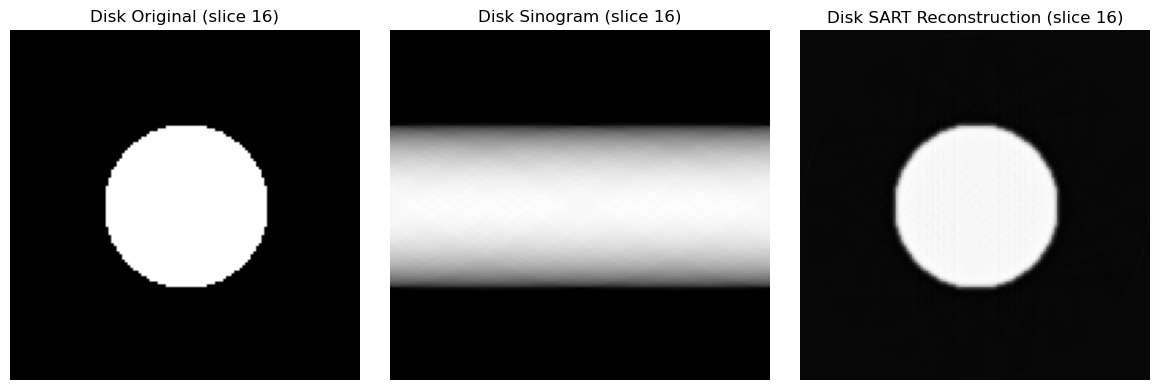

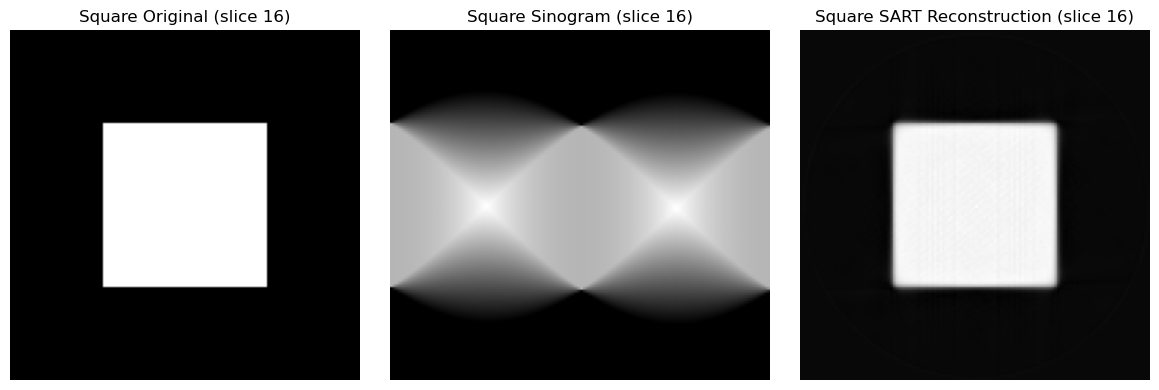

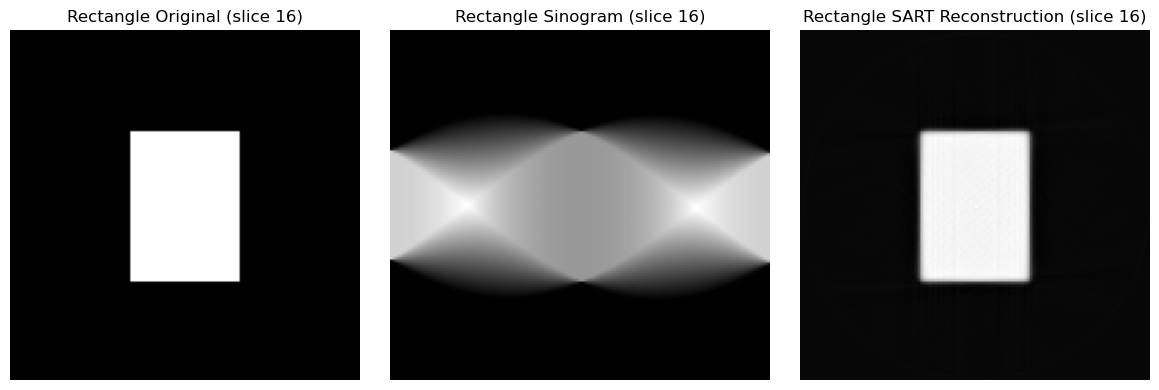

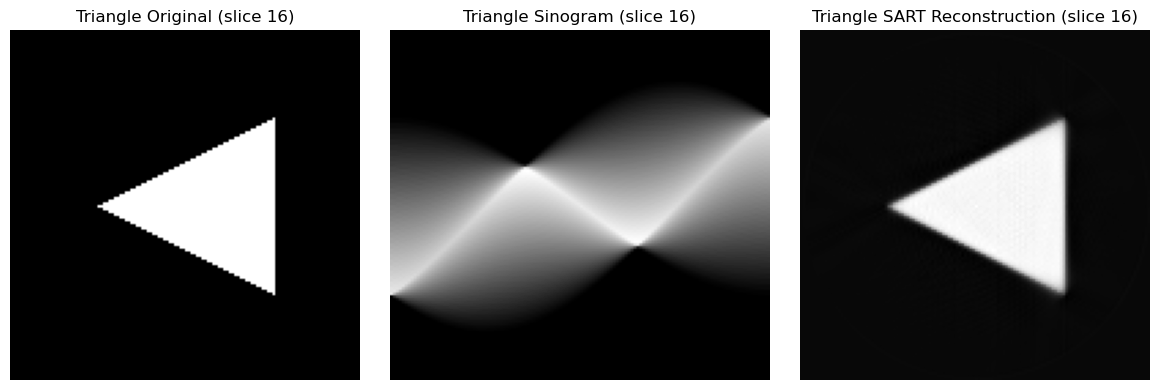

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

In [2]:
# Code with better implementation of SART 
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk, rectangle, polygon
from skimage.transform import radon, iradon_sart
import matplotlib.pyplot as plt 
from ipywidgets import interact 

size = 128  # slice image size
num_slices = 32  # number of slices for 3D volume

# helper functions for shape generation
def make_blank(size=size):
    return np.zeros((size, size), dtype=float)

def make_disk(size=size, radius=40, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    rr, cc = disk(center, radius, shape=img.shape)
    img[rr, cc] = intensity
    return img

def make_square(size=size, side=60, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    half = side//2
    start = (center[0]-half, center[1]-half)
    rr, cc = rectangle(start, extent=(side, side), shape=img.shape)
    img[rr, cc] = intensity
    return img

def make_rectangle(size=size, width=40, height=80, center=None, intensity=1.0):
    img = make_blank(size)
    if center is None:
        center = (size//2, size//2)
    start = (center[0]-height//2, center[1]-width//2)
    rr, cc = rectangle(start, extent=(height, width), shape=img.shape)
    img[rr, cc] = intensity
    return img

def make_triangle(size=size, intensity=1.0):
    img = make_blank(size)
    v = np.array([
        # left bottom 
        [size//4, 3*size//4],
        # top middle 
        [size//2, size//4],
        # right bottom
        [3*size//4, 3*size//4]
    ])
    # polygon returns rr - row indices of all pixels 
    # and returns cc - col indices of all pixels
    rr, cc = polygon(v[:,0], v[:,1], img.shape)
    # color the triangle
    img[rr, cc] = intensity
    return img

# create 3D phantoms by stacking slightly varying 2D slices
phantom_disks = []
phantom_squares = []
phantom_rects = []
phantom_triangles = []
for i in range(num_slices):
    # slight variations in each slice for 3D "effect"
    # helps us oscillate the radius by +- 10 pixels
    phantom_disks.append(make_disk(radius=30 + int(10 * np.sin(2 * np.pi * i / num_slices))))
    # changes the vertical center of the square by +- 5 pixels
    center_shift = (size//2 + int(5 * np.sin(2 * np.pi * i / num_slices)), size//2)
    # creates a new square at its shifted position
    phantom_squares.append(make_square(center=center_shift))
    # osicllates the hegiht by +- 15 pixels 
    height = 70 + int(15 * np.cos(2 * np.pi * i / num_slices))
    # creates and saves a rect of the calculated height
    phantom_rects.append(make_rectangle(height=height))
    # we use sine wave to shift triangle's horizontal position
    shift = int(5 * np.sin(2 * np.pi * i / num_slices))
    # we make triangle's 3 vertices all moved by shift
    t_img = make_blank()
    v = np.array([
        [size//4 + shift, 3*size//4],
        [size//2 + shift, size//4],
        [3*size//4 + shift, 3*size//4]
    ])
    rr, cc = polygon(v[:,0], v[:,1], t_img.shape)
    t_img[rr, cc] = 1.0
    phantom_triangles.append(t_img)

# stack the lists into 3D arrays
phantom_disks = np.stack(phantom_disks)
phantom_squares = np.stack(phantom_squares)
phantom_rects = np.stack(phantom_rects)
phantom_triangles = np.stack(phantom_triangles)

# sinogram and SART reconstruction for each slice

# theta values from 0->180
theta = np.linspace(0., 180., size, endpoint=False)

def reconstruct_stack(phantom_stack):
    # make sinograms for all the stacks 
    sinograms = np.array([radon(phantom_stack[i], theta=theta, circle=True) for i in range(num_slices)])
    # reconstruc the images for all the stacks 
    recons = np.array([iradon_sart(sinograms[i], theta=theta) for i in range(num_slices)])
    return sinograms, recons

sino_disks, rec_disks = reconstruct_stack(phantom_disks)
sino_squares, rec_squares = reconstruct_stack(phantom_squares)
sino_rects, rec_rects = reconstruct_stack(phantom_rects)
sino_triangles, rec_triangles = reconstruct_stack(phantom_triangles)

# visualizations
slice_idx = num_slices // 2

# function to print the visualizations 
def show_slice_set(origin, sino, rec, name):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(origin, cmap='gray')
    plt.title(f'{name} Original (slice {slice_idx})')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(sino, cmap='gray', aspect='auto')
    plt.title(f'{name} Sinogram (slice {slice_idx})')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(rec, cmap='gray')
    plt.title(f'{name} SART Reconstruction (slice {slice_idx})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# function to show the volume of the images as well 
def show_volume(volume, title = ''):
    def view_slice(idx):
        plt.figure(figsize = (5,5))
        plt.imshow(volume[idx], cmap = 'gray')
        plt.title(f'{title}, slice {idx}')
        plt.axis('off')
        plt.show()
    interact(view_slice, idx = (0, volume.shape[0]-1))



show_slice_set(phantom_disks[slice_idx], sino_disks[slice_idx], rec_disks[slice_idx], 'Disk')
show_slice_set(phantom_squares[slice_idx], sino_squares[slice_idx], rec_squares[slice_idx], 'Square')
show_slice_set(phantom_rects[slice_idx], sino_rects[slice_idx], rec_rects[slice_idx], 'Rectangle')
show_slice_set(phantom_triangles[slice_idx], sino_triangles[slice_idx], rec_triangles[slice_idx], 'Triangle')

# outputs with the volume
show_volume(rec_disks, title = 'Disk SART Reconstruction')
show_volume(rec_squares, title = 'Rectangle SART Reconstruction')
show_volume(rec_rects, title = 'Square SART Reconstruction')
show_volume(rec_triangles, title = 'Triangle SART Reconstruction')

/opt/miniconda3/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


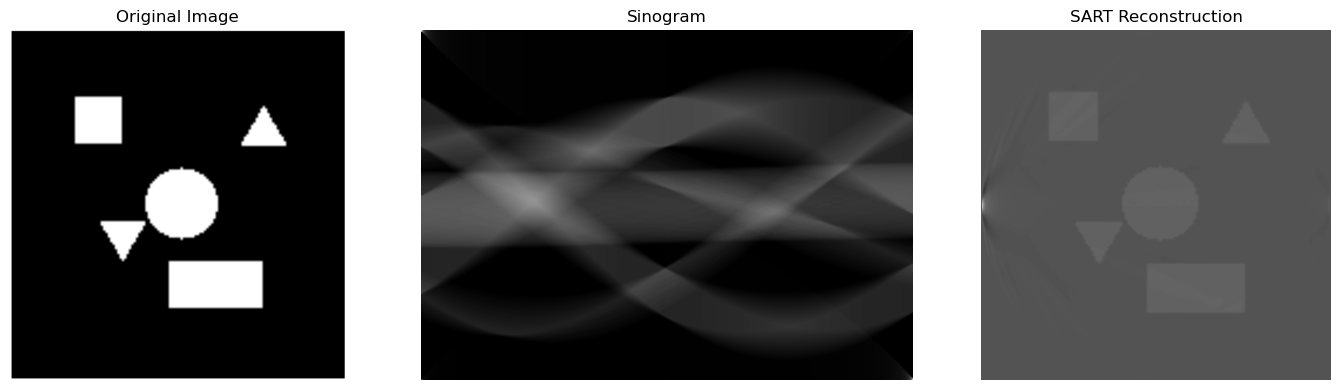

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import radon, iradon_sart

# load the image 
img = imread('input_image.png')  
if img.ndim == 3 and img.shape[2] == 4:
    img = img[..., :3]  # keep only R, G, B channels
if img.ndim == 3:
    img = rgb2gray(img)


# generate sinogram
size = img.shape[0]
theta = np.linspace(0., 180., size, endpoint=False)
sinogram = radon(img, theta=theta, circle=True)

# reconstruction 
reconstruction_sart = iradon_sart(sinogram, theta=theta)

# results
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title('Sinogram')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(reconstruction_sart, cmap='gray')
plt.title('SART Reconstruction')
plt.axis('off')
plt.tight_layout()
plt.show()


/opt/miniconda3/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


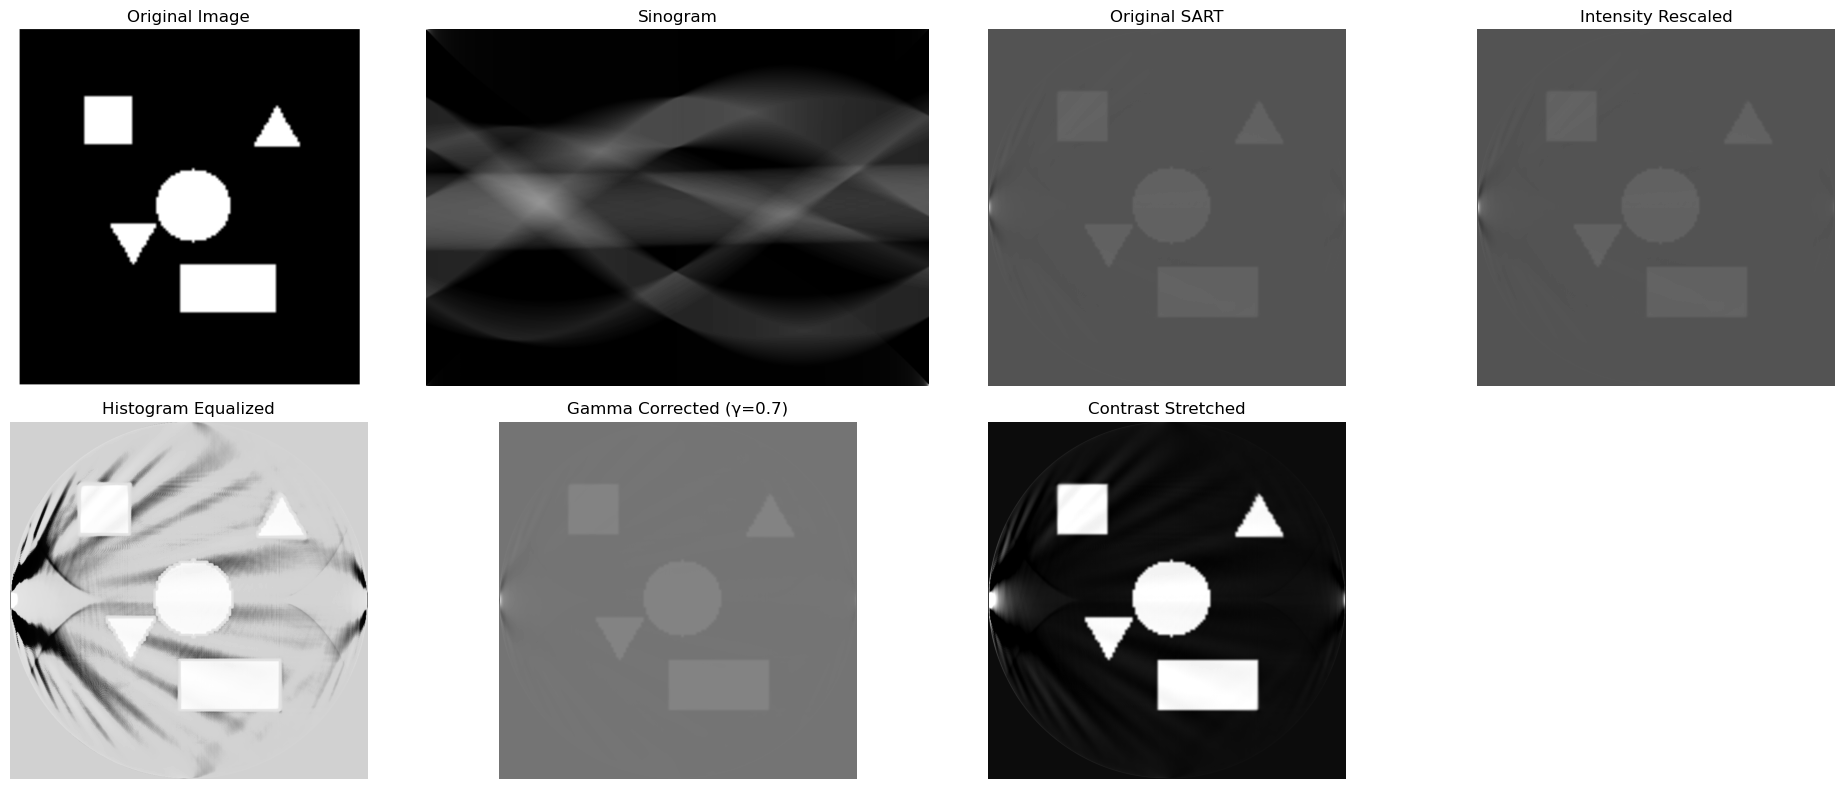

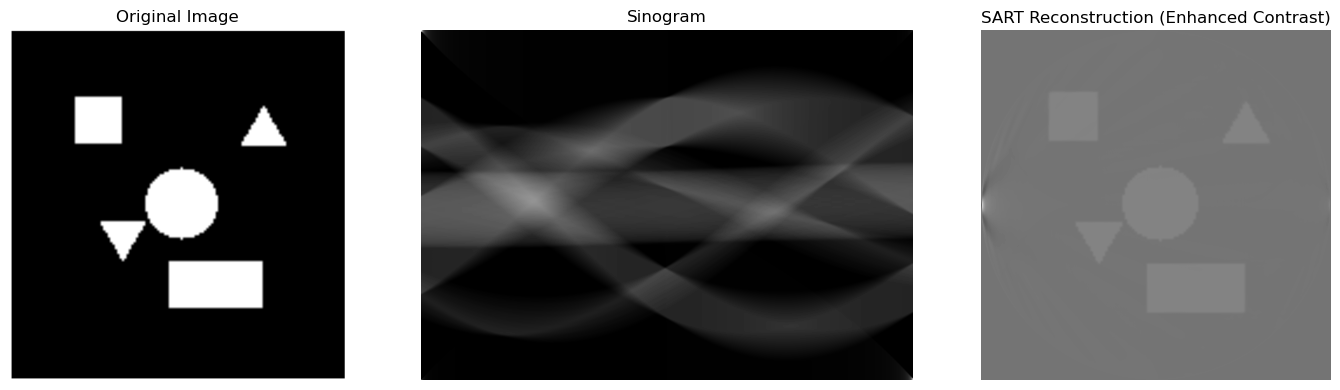

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import radon, iradon_sart
from skimage import exposure

# Load the image 
img = imread('input_image.png')  
if img.ndim == 3 and img.shape[2] == 4:
    img = img[..., :3]  # keep only R, G, B channels
if img.ndim == 3:
    img = rgb2gray(img)

# Generate sinogram
size = img.shape[0]
theta = np.linspace(0., 180., size, endpoint=False)
sinogram = radon(img, theta=theta, circle=True)

# Reconstruction using sart (iradon_sart)
reconstruction_sart = iradon_sart(sinogram, theta=theta)

# trying to enhance the quality
# method 1: Rescale intensity to use full [0,1] range
# Makes the darkest pixel pure black (0) and brightest pixel pure white (1)
recon_rescaled = exposure.rescale_intensity(reconstruction_sart, in_range='image', out_range=(0, 1))

# method 2: Histogram equalization for adaptive contrast
# Flattens out the brightness distribution - brings out hidden details
recon_equalized = exposure.equalize_hist(reconstruction_sart)

# Method 3: Gamma correction (gamma < 1 brightens, gamma > 1 darkens)
# Fine-tunes brightness without losing details in very dark/bright areas
recon_gamma = exposure.adjust_gamma(recon_rescaled, gamma=0.7)

# Method 4: Contrast stretching (percentile-based)
#  Ignores noise/artifacts and focuses on enhancing the actual image content
p2, p98 = np.percentile(reconstruction_sart, (2, 98))
recon_stretched = exposure.rescale_intensity(reconstruction_sart, in_range=(p2, p98))

# VISUALIZATION: Compare all methods
plt.figure(figsize=(20, 8))

# Original and sinogram
plt.subplot(2, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title('Sinogram')
plt.axis('off')

# Original reconstruction
plt.subplot(2, 4, 3)
plt.imshow(reconstruction_sart, cmap='gray')
plt.title('Original SART')
plt.axis('off')

# Enhanced versions
plt.subplot(2, 4, 4)
plt.imshow(recon_rescaled, cmap='gray')
plt.title('Intensity Rescaled')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(recon_equalized, cmap='gray')
plt.title('Histogram Equalized')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(recon_gamma, cmap='gray')
plt.title('Gamma Corrected (γ=0.7)')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(recon_stretched, cmap='gray')
plt.title('Contrast Stretched')
plt.axis('off')

plt.tight_layout()
plt.show()

# Most commonly effective for CT images:
final_result = recon_gamma  # or recon_rescaled, depending on what looks best

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title('Sinogram')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_result, cmap='gray')
plt.title('SART Reconstruction (Enhanced Contrast)')
plt.axis('off')

plt.tight_layout()
plt.show()


/opt/miniconda3/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


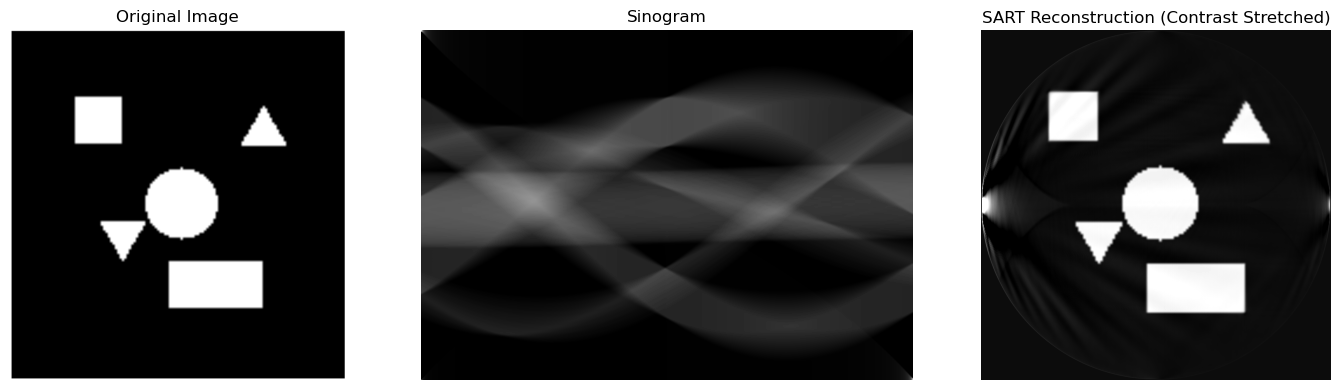

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import radon, iradon_sart
from skimage import exposure

# Load the image 
img = imread('input_image.png')  
if img.ndim == 3 and img.shape[2] == 4:
    img = img[..., :3]  # keep only R, G, B channels
if img.ndim == 3:
    img = rgb2gray(img)

# Generate sinogram
size = img.shape[0]
theta = np.linspace(0., 180., size, endpoint=False)
sinogram = radon(img, theta=theta, circle=True)

# Reconstruction 
reconstruction_sart = iradon_sart(sinogram, theta=theta)

# contrast strechting 
p2, p98 = np.percentile(reconstruction_sart, (2, 98))
recon_stretched = exposure.rescale_intensity(reconstruction_sart, in_range=(p2, p98))

# display the final results
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title('Sinogram')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(recon_stretched, cmap='gray')
plt.title('SART Reconstruction (Contrast Stretched)')
plt.axis('off')

plt.tight_layout()
plt.show()
